<a href="https://colab.research.google.com/github/tobiasuruali/WebScraper_PolAds/blob/main/05_gpt_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount your Google Drive Folders
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip -qqq install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00
time: 454 µs (started: 2023-04-28 14:02:20 +00:00)


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Google_Pol_Ads')
print(os.listdir())
print(os.getcwd())

['data', 'env']
/content/drive/MyDrive/Google_Pol_Ads
time: 5.84 ms (started: 2023-04-28 14:02:20 +00:00)


In [ ]:
import pandas as pd

# Load the CSV file from Google Drive
df_trump = pd.read_csv('data/data_processed/df_trump_text.csv')

# Load the CSV file from Google Drive
df_biden = pd.read_csv('data/data_processed/df_biden_text.csv')

# Display the first 5 rows of the DataFrame
df_trump.head()


,ad_id,date_range_start,ad_url,advertiser_id,advertiser_name,youtube_url,ad_text
0,CR06816033659036893185,2020-03-12,https://adstransparency.google.com/advertiser/...,AR12365610929977556993,BIDEN FOR PRESIDENT,https://www.youtube.com/watch?v=1tPFGsOivHM&em...,"Cuando Joe Biden se enfrentó al NRA, logró qu..."
1,CR17518932181727051777,2020-10-14,https://adstransparency.google.com/advertiser/...,AR12365610929977556993,BIDEN FOR PRESIDENT,https://www.youtube.com/watch?v=_C-WvLV5UII&em...,People have been denied the right to vote. Fi...
2,CR17406877790644469761,2020-09-08,https://adstransparency.google.com/advertiser/...,AR12365610929977556993,BIDEN FOR PRESIDENT,https://www.youtube.com/watch?v=MSZO8zPUYL0&em...,My future and the future of everyone my age d...
3,CR17616576648293908481,2020-07-16,https://adstransparency.google.com/advertiser/...,AR12365610929977556993,BIDEN FOR PRESIDENT,https://www.youtube.com/watch?v=uLwYRdUxNcY&em...,"After a car crash changed his life forever, J..."
4,CR14354267786883104769,2020-08-11,https://adstransparency.google.com/advertiser/...,AR12365610929977556993,BIDEN FOR PRESIDENT,https://www.youtube.com/watch?v=7ShIz1wlcSw&em...,Leadership is built on trust. Joe Biden led t...


time: 97.7 ms (started: 2023-04-28 14:03:52 +00:00)


In [ ]:
df_biden.head()

# Sentiment Analysis

As Sentiment Analysis we will use a novice approach. 
We will use OpenAi's GPT-3 Model to do the Sentiment Analysis for us. 
Andrew Ng in his new [Prompt Engineering class](https://learn.deeplearning.ai/chatgpt-prompt-eng/) explains how GPT models can be super useful for developers as well. 

Inspired by his class, we will feed model with our own prompt and hopefully get a useful sentiment analysis result out of it. We will define the model output us a Sentiment Score between -1 and 1. 

In [ ]:
!pip -qqq install openai
!pip -qqq install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.1 MB/s eta 0:00:00
time: 16.3 s (started: 2023-04-28 14:05:20 +00:00)


In [ ]:
import openai
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv("env/.env")) # read local .env file

openai.api_key  = os.getenv('OPENAI_API_KEY')

time: 428 ms (started: 2023-04-28 14:15:46 +00:00)


Now we'll create a prompt to let GPT3.5 create our sentiment analysis

In [ ]:
def get_sentiment_scores(df, column):
    def get_completion(prompt, model="gpt-3.5-turbo"):
        messages = [{"role": "user", "content": prompt}]
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=0,
        )
        return response.choices[0].message["content"]

    # Create a new DataFrame to store the results
    result = df.copy()

    # Iterate over the rows in the input DataFrame
    for i, row in df.iterrows():
        # Get the ad text
        ad_text = row[column]

        # Creating the prompts, there was a lot prompt engineering happening
        # Without the last sentence, gpt-3.5 would always define the sentiment score as 0.1 or -0.1
        # After Adjusting the prompt to be more sensitive to "neutral" seeming text. The output reflect more of what the text said.
        prompt = f"""
        You are a Sentiment Analysis Expert in Political Advertising.
        What is the sentiment of the following Political Campaign Text?

        On a scale of -1 to 1, with -1 being negative and 1 being positive, please provide the sentiment score of the text as accurately as possible, including decimal points. Reply without explanation, ONLY a single number!
        Your output shall never be exactly 0. It should at least indicate a number that's slightly positive or negative. Please be more sensitive to neutral texts and provide a score that reflects the overall sentiment of the text.

        Advertisement Text: '''{ad_text}'''
        """

        # Get the sentiment score
        sentiment_score = get_completion(prompt)

        # Store the sentiment score in the result DataFrame
        result.loc[i, 'ad_sentiment_score'] = sentiment_score

    # Convert the ad_sentiment_score column to numeric values
    result['ad_sentiment_score'] = pd.to_numeric(result['ad_sentiment_score'], errors='coerce')
    print(result['ad_sentiment_score'])

    return result

time: 6.34 ms (started: 2023-04-28 14:43:48 +00:00)


In [ ]:
df_trump_with_scores = get_sentiment_scores(df_trump, 'ad_text')
df_biden_with_scores = get_sentiment_scores(df_biden, 'ad_text')

0     0.1
1     0.4
2    -0.8
3    -0.6
4    -0.8
5     0.2
6    -0.2
7     0.1
8     0.4
9     0.2
10    0.8
11   -0.6
12    0.2
13    0.2
14    0.5
15    0.1
16   -0.8
17   -0.7
18   -0.2
19    0.2
20    0.2
21    0.2
22    0.3
23    0.5
24   -0.8
Name: ad_sentiment_score, dtype: float64
0     0.4
1    -0.4
2     0.4
3     0.4
4     0.6
5     0.4
6    -0.4
7    -0.4
8     0.1
9    -0.4
10    0.1
11    0.4
12    0.6
13    0.4
14    0.6
15    0.6
16   -0.6
17    0.4
18    0.4
19    0.4
20    0.5
21    0.2
22    0.4
23    0.5
24    0.6
Name: ad_sentiment_score, dtype: float64
time: 44.1 s (started: 2023-04-28 14:43:53 +00:00)


In [ ]:
print(df_trump_with_scores['ad_sentiment_score'].mean())
df_trump_with_scores.head()

-0.036000000000000004


,ad_id,date_range_start,ad_url,advertiser_id,advertiser_name,youtube_url,ad_text,ad_sentiment_score
0,CR08940881523716915201,2019-06-17,https://adstransparency.google.com/advertiser/...,AR07331491169769095169,TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE,https://www.youtube.com/watch?v=sw-gi-vpMII&em...,Alison Rickman shows footage of music perform...,0.1
1,CR15841802428220440577,2019-05-31,https://adstransparency.google.com/advertiser/...,AR07331491169769095169,TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE,https://www.youtube.com/watch?v=m0vuun_0xfA&em...,"Hey everybody, I'm Laura Trump. The 1 million...",0.4
2,CR06248814851720740865,2020-09-30,https://adstransparency.google.com/advertiser/...,AR11825178974693097473,"DONALD J. TRUMP FOR PRESIDENT, INC.",https://www.youtube.com/watch?v=64Cu86cKqYM&em...,Biden's plan is not a solution. It is a virtu...,-0.8
3,CR12027210250567286785,2020-09-30,https://adstransparency.google.com/advertiser/...,AR11825178974693097473,"DONALD J. TRUMP FOR PRESIDENT, INC.",https://www.youtube.com/watch?v=zSud9Wz0hS0&em...,Joe Biden tried to cut Social Security and Me...,-0.6
4,CR05051279563305254913,2020-10-13,https://adstransparency.google.com/advertiser/...,AR11825178974693097473,"DONALD J. TRUMP FOR PRESIDENT, INC.",https://www.youtube.com/watch?v=9zXPq-WylNM&em...,You're gonna take care of the gun problem wit...,-0.8


time: 22.9 ms (started: 2023-04-28 14:45:50 +00:00)


Lets evaluate the output:

In [ ]:
pd.set_option('display.max_colwidth', None)
print(df_trump_with_scores.loc[2,[ 'ad_sentiment_score', 'ad_text']])

ad_sentiment_score                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   -0.8
ad_text                Biden's plan is not a solution. It is a virtual surrender. Biden's plan for the China virus is to shut down the entire U.S. economy. I would shut it down. No miracle is coming. If I were president today, I would roll back the reopenings in a number of places. Biden wants to surrender our country to the virus. He wants to surrender our families to the pilot left-wing mob. And he wants to surrender our jobs to China. I wo

Based on this example from the Trump Sentiment Dataset. It seems like GPT has done a fairly well job. The substance of that text is very negative, so it makes sense that GPT3.5 would score it with a -0.8

In [ ]:
pd.set_option('display.max_colwidth', 50)
print(df_trump_with_scores['ad_sentiment_score'].mean())
print(df_trump_with_scores[['ad_sentiment_score','ad_text']].head(15))

-0.036000000000000004
    ad_sentiment_score                                            ad_text
0                  0.1   Alison Rickman shows footage of music perform...
1                  0.4   Hey everybody, I'm Laura Trump. The 1 million...
2                 -0.8   Biden's plan is not a solution. It is a virtu...
3                 -0.6   Joe Biden tried to cut Social Security and Me...
4                 -0.8   You're gonna take care of the gun problem wit...
5                  0.2                               Thanks for watching!
6                 -0.2   if things weren't already like this Sentry La...
7                  0.1                                                  ♪
8                  0.4   In the last two years, our brave ICE officers...
9                  0.2   No one is going to hand us the agenda we vote...
10                 0.8   They said it couldn't be done, but President ...
11                -0.6   Democrats have become the party of open borde...
12              

In [ ]:
pd.set_option('display.max_colwidth', 50)
print(df_biden_with_scores['ad_sentiment_score'].mean())
print(df_biden_with_scores[['ad_sentiment_score','ad_text']].head(15))

0.24799999999999997
    ad_sentiment_score                                            ad_text
0                  0.4   Cuando Joe Biden se enfrentó al NRA, logró qu...
1                 -0.4   People have been denied the right to vote. Fi...
2                  0.4   My future and the future of everyone my age d...
3                  0.4   After a car crash changed his life forever, J...
4                  0.6   Leadership is built on trust. Joe Biden led t...
5                  0.4   Cuando Joe Biden se enfrentó al NRA, logró qu...
6                 -0.4   When Trump lost control of the coronavirus, A...
7                 -0.4   When you've lost your job and your insurance,...
8                  0.1                                                  🎵
9                 -0.4   Nearly one in six small businesses is closed ...
10                 0.1                                              Okay.
11                 0.4   Teaching is not what you do, it's who you are...
12                

## Plots
Lets try and combine and compare the sentiment score of both datasets.

In [ ]:
df_trump_with_scores['ad_person'] = 'Trump'
df_biden_with_scores['ad_person'] = 'Biden'

# Combine the two DataFrames into one
df_us_video = pd.concat([df_trump_with_scores, df_biden_with_scores], ignore_index=True)

# Display the first 5 rows of the combined DataFrame
print(df_us_video.head())


                    ad_id date_range_start  \
0  CR08940881523716915201       2019-06-17   
1  CR15841802428220440577       2019-05-31   
2  CR06248814851720740865       2020-09-30   
3  CR12027210250567286785       2020-09-30   
4  CR05051279563305254913       2020-10-13   

                                              ad_url           advertiser_id  \
0  https://adstransparency.google.com/advertiser/...  AR07331491169769095169   
1  https://adstransparency.google.com/advertiser/...  AR07331491169769095169   
2  https://adstransparency.google.com/advertiser/...  AR11825178974693097473   
3  https://adstransparency.google.com/advertiser/...  AR11825178974693097473   
4  https://adstransparency.google.com/advertiser/...  AR11825178974693097473   

                            advertiser_name  \
0  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
1  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
2       DONALD J. TRUMP FOR PRESIDENT, INC.   
3       DONALD J. TRUMP FOR PRESIDENT, INC.   
4      

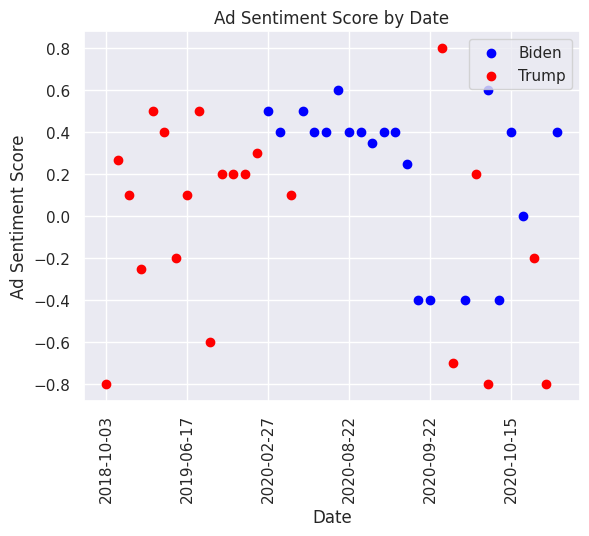

time: 2.04 s (started: 2023-04-28 15:19:12 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn theme
sns.set_theme()

# Get the data to plot
data = df_us_video.groupby(['date_range_start', 'ad_person'])['ad_sentiment_score'].mean().unstack()

# Create a new figure and axes
fig, ax = plt.subplots()

# Define the colors for each person
colors = {'Biden': 'blue', 'Trump': 'red'}

# Create a scatter plot for each person
for person in data.columns:
    ax.scatter(data.index, data[person], label=person, color=colors[person])

# Set the title and axis labels
ax.set_title('Ad Sentiment Score by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Ad Sentiment Score')

# Get the tick locations and labels
locs, labels = plt.xticks()

# Set the tick locations and labels to show only every 7th label
plt.xticks(locs[::7], labels[::7], rotation=90)

# Add a legend
ax.legend()

# Save the plot as an image file
fig.savefig('ad_sentiment_biden_trump.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Save the DataFrame as a CSV file
df_us_video.to_csv('data/data_processed/us_biden_trump_video_text_sent.csv', index=False)


time: 27.7 ms (started: 2023-04-28 15:24:05 +00:00)
